In [89]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision.transforms as T
from flow_models.PatchFlowModel import PatchFlowModel
from img_utils import ImageLoader
from patch_flow_trainer import patch_flow_trainer
from transforms import image_dequantization, image_normalization
import sqlite3

In [90]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
patch_size = 7

In [12]:
def log_likelihood_loss(z, z_log_det):
    return torch.mean(0.5 * torch.sum(z**2, dim=1) - z_log_det)

In [5]:
model = PatchFlowModel(hparams={"num_layers": 5, "sub_net_size": 512, "dimension": patch_size ** 2}) #create_NF(num_layers=10, sub_net_size=512, dimension=patch_size**2)

In [6]:
deq_normalization = T.Compose([
    #image_dequantization(device=DEVICE),
    image_normalization()])

In [7]:
train_images = ImageLoader('data/material_pt_nr/train.png', transform=deq_normalization, device=DEVICE)
validation_images = ImageLoader('data/material_pt_nr/validate.png', transform=deq_normalization, device=DEVICE)

In [8]:
patch_flow_trainer('custom_patch_nr', 'results/patch_nr', model, log_likelihood_loss, train_images, validation_images, steps=3000, patch_size=patch_size, device=DEVICE)

Started training for model custom_patch_nr. 
 Will train 3000 steps in device=cuda
The weights, loss and the parameters will be stored at this location: results/patch_nr/custom_patch_nr/version_3


  0%|          | 0/3000 [00:00<?, ?it/s]

Optimizer is initialized with this parameters: {'state': {}, 'param_groups': [{'lr': 0.005, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]}]}


T: -169.25857543945312, V:-177.59494018554688: 100%|██████████| 3000/3000 [00:47<00:00, 63.55it/s]


RuntimeError: Parent directory results/patch_nr/custom_patch_nr/version_3 does not exist.

In [91]:
connection = sqlite3.connect('results/patch_nr/custom_patch_nr/version_1/loss.db')
cursor = connection.cursor()
result = np.array(cursor.execute("SELECT * from flow_model_train_loss order by step").fetchall())

In [92]:
x = result[:, 0]
loss = result[:, 1]

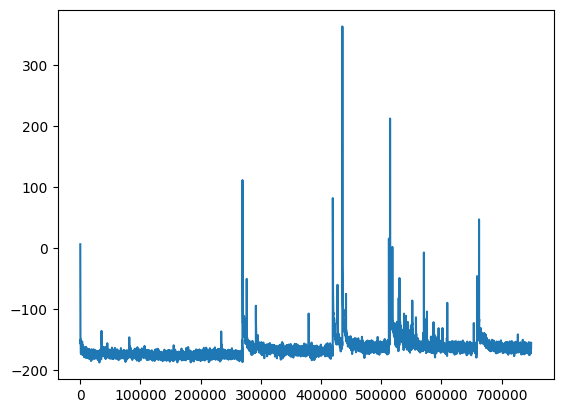

In [93]:
plt.plot(x, loss)